Recreating code from:
https://gist.github.com/vmarkovtsev/74e3a973b19113047fdb6b252d741b42

In [1]:
%qtconsole

import pickle
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import umap

import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = fetch_mldata('MNIST original', data_home=".")

In [3]:
n_rows = np.sqrt(mnist["data"].shape[1]).astype(int)

mnist["data"].shape

(70000, 784)

In [4]:
size = 50
N = size * size
data, target = shuffle(mnist["data"], mnist["target"], random_state=777, n_samples=N)

In [15]:
embeddings = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(data)

embeddings -= embeddings.min(axis=0)
embeddings /= embeddings.max(axis=0)

In [6]:
data_100 = PCA(n_components=100).fit_transform(data.astype(np.float32) / 255)
embeddings = TSNE(init="pca", random_state=777, verbose=2).fit_transform(data_100)
embeddings -= embeddings.min(axis=0)
embeddings /= embeddings.max(axis=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.010s...
[t-SNE] Computed neighbors for 2500 samples in 1.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 2.333898
[t-SNE] Computed conditional probabilities in 0.088s
[t-SNE] Iteration 50: error = 77.5855713, gradient norm = 0.0031623 (50 iterations in 3.007s)
[t-SNE] Iteration 100: error = 77.6927719, gradient norm = 0.0003676 (50 iterations in 2.915s)
[t-SNE] Iteration 150: error = 77.6936569, gradient norm = 0.0006567 (50 iterations in 2.945s)
[t-SNE] Iteration 200: error = 77.6934280, gradient norm = 0.0003155 (50 iterations in 2.902s)
[t-SNE] Iteration 250: error = 77.6927872, gradient norm = 0.0003145 (50 iterations in 2.838s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.692787
[t-SNE] Iteration 300: erro

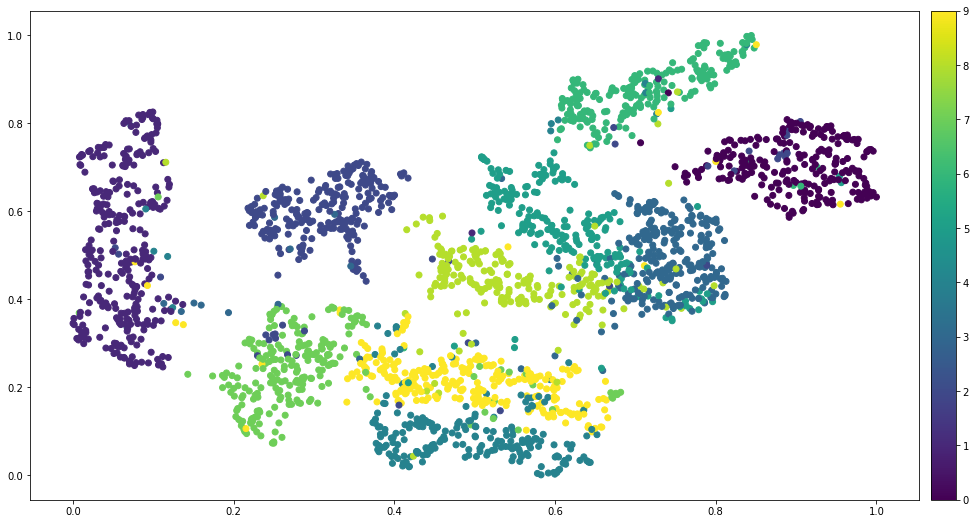

In [16]:
plt.figure(figsize=(17, 9))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=target)
my_colorbar = plt.colorbar(fraction=0.05, pad = 0.0125)

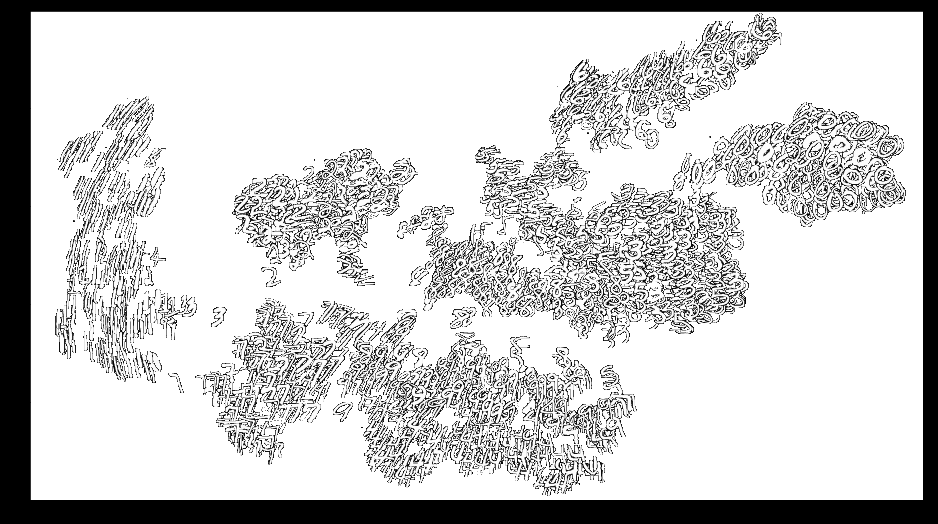

In [17]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
fig.set_facecolor('black')

for pos, img in zip(embeddings, data):
    img = img.reshape(n_rows, n_rows)
    img = np.stack((img, img, img, np.ones((n_rows, n_rows), dtype=np.uint8) * 255), axis=-1)
    img[img[:, :, 0] == 0] = 0
    ab = AnnotationBbox(OffsetImage(img), 0.03 + pos * 0.94, xycoords="axes fraction", frameon=False)
    ax.add_artist(ab)

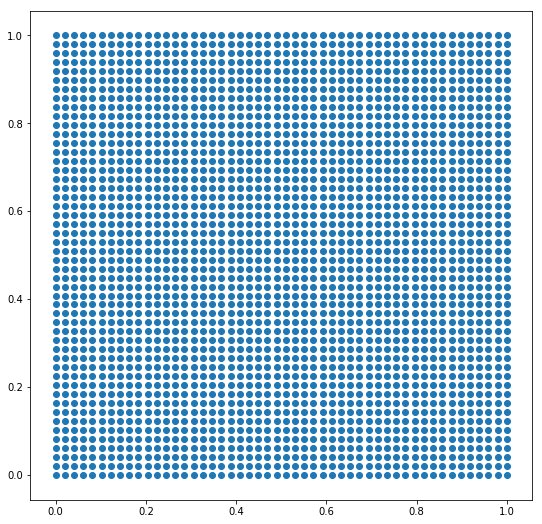

In [18]:
from scipy.spatial.distance import cdist
grid = np.dstack(np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))).reshape(-1, 2)
plt.figure(figsize=(9, 9))
plt.scatter(grid[:,0], grid[:,1]);

In [19]:
from lap import lapjv

cost_matrix = cdist(grid, embeddings, "sqeuclidean").astype(np.float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())
%time _, row_assignments, col_assignments = lapjv(cost_matrix)

CPU times: user 11.5 s, sys: 113 ms, total: 11.6 s
Wall time: 12.5 s


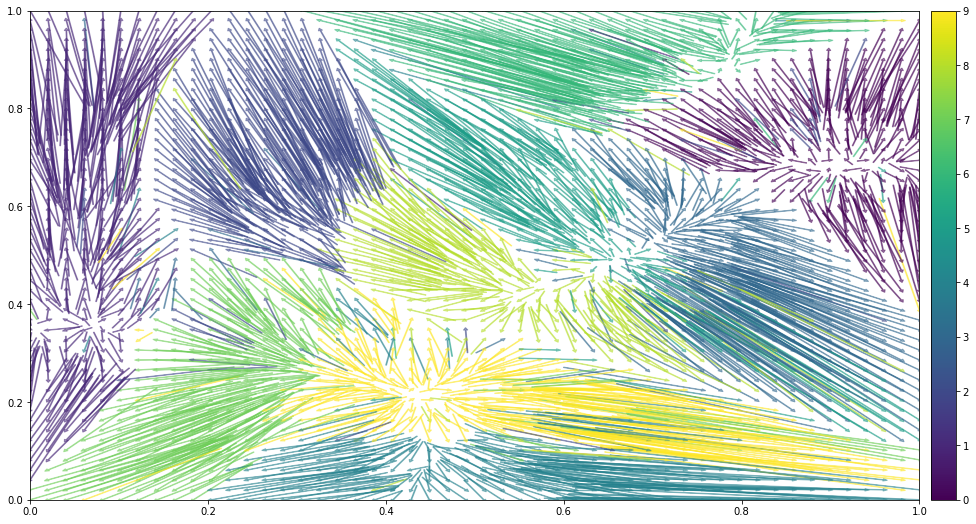

In [20]:
grid_jv = grid[col_assignments]
pp_cmap = plt.cm.get_cmap(plt.rcParams["image.cmap"])
plt.figure(figsize=(17, 9))

for start, end, t in zip(embeddings, grid_jv, target):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.005, head_width=0.005, color=pp_cmap(t / target.max()), alpha=0.5)
plt.colorbar(my_colorbar.mappable, fraction=0.05, pad = 0.0125);

(0, 1388)

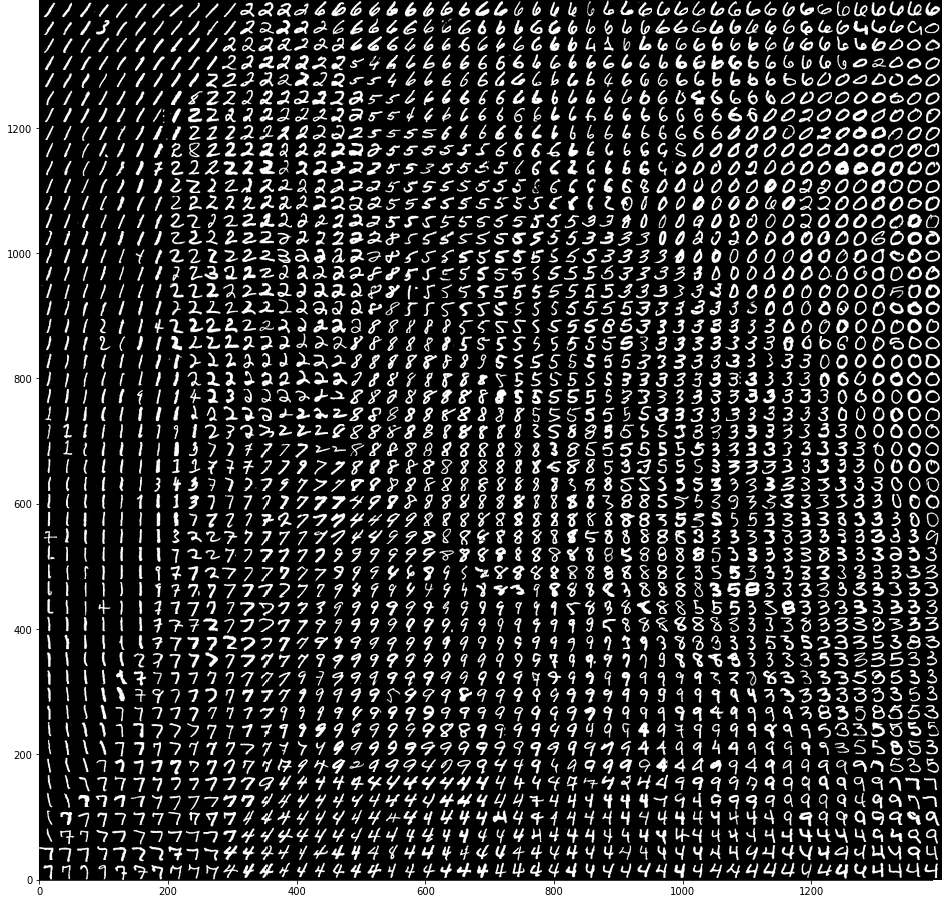

In [21]:
from PIL import Image

plt.figure(figsize=(16, 16))
plt.gca().set_facecolor("black")

for pos, img in zip(grid_jv, data):
    img = Image.fromarray(255 - img.reshape(n_rows, n_rows)).resize((20, 20), Image.ANTIALIAS)
    ab = AnnotationBbox(OffsetImage(img, cmap="Greys"),
                        pos * (size - 1) * n_rows, xycoords="data",
                        frameon=False, box_alignment=(0, 0))
    plt.gca().add_artist(ab)
plt.xlim(0, (size - 1) * 28 + 16)
plt.ylim(0, (size - 1) * 28 + 16)
